###### Project

In [727]:
import pandas as pd
#import sqlite3
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import datetime as dt
import folium
from folium import plugins
import geopandas
from calendar import monthrange

spray_data = pd.read_csv(
    'Files/spray.csv',  # шлях до файлу, який містить дані
    sep=',',  # роздільник стовпців
    header=0  # номер рядка, що містить заголовок (якщо заголовка немає, можна передати None)
)

train_data = pd.read_csv(
    'Files/train.csv',  # шлях до файлу, який містить дані
    sep=',',  # роздільник стовпців
    
    header=0  # номер рядка, що містить заголовок (якщо заголовка немає, можна передати None)
)

weather_data = pd.read_csv(
    'Files/weather.csv',  # шлях до файлу, який містить дані
    sep=',',  # роздільник стовпців
    header=0  # номер рядка, що містить заголовок (якщо заголовка немає, можна передати None)
)

test_truncated_data = pd.read_excel(
    'Files/test_truncated.xlsx',
    sheet_name='test_truncated',  # прочитати всі листи
    usecols="A:J"
    #nrows=5
)


In [728]:
def add_datetime(train_data):
    train_data['day']=pd.to_datetime(train_data.Date).dt.day
    train_data['weekday']=pd.to_datetime(train_data.Date).dt.weekday
    train_data['month']=pd.to_datetime(train_data.Date).dt.month
    train_data['year']=pd.to_datetime(train_data.Date).dt.year
    return train_data

def bar_chat(_data, grop_list_, agr_colum, agr_func):
    grop_list=[grop_list_]
    agg_func_math = {
        agr_colum: [agr_func]
    }
    plot_mas = _data.groupby(grop_list, group_keys=True, dropna=True).agg(agg_func_math).to_dict()[(agr_colum, agr_func)] 
    fig = plt.figure()
    plt.bar(plot_mas.keys(), plot_mas.values())
    plt.title(f'{grop_list_} {agr_colum} {agr_func} chart')    
    plt.grid(True)   # лінії допоміжної сітки
#bar_chat(test_truncated_data, 'year', 'year', 'count')

def group_data(_data, grop_list_, agr_colum, agr_func):
    grop_list=[grop_list_]
    agg_func_math = {
        agr_colum: [agr_func]
    }
    dict_data=_data.groupby(grop_list, group_keys=True, dropna=True).agg(agg_func_math).to_dict()[(agr_colum, agr_func)]
    df=pd.DataFrame(list(dict_data. items ()), columns = [grop_list_, agr_colum])
    #df.set_index(df[grop_list], *, drop=True, append=False, inplace=False, verify_integrity=False)[source]
    df.set_index(grop_list, inplace=True)
    return df.copy()

def concat_data(train_data):
    Trap=group_data(train_data, 'Trap', 'Latitude', 'min')
    Longitude=group_data(train_data, 'Trap', 'Longitude', 'min')
    NumMosquitos=group_data(train_data, 'Trap', 'NumMosquitos', 'sum')
    WnvPresent=group_data(train_data, 'Trap', 'WnvPresent', 'sum')
    AddressAccuracy=group_data(train_data, 'Trap', 'AddressAccuracy', 'min')
    RESTUANS=group_data(train_data, 'Trap', 'RESTUANS', 'sum')
    PIPIENS=group_data(train_data, 'Trap', 'PIPIENS', 'sum')
    Date_Min=group_data(train_data, 'Trap', 'Date', 'min')
    #Date_Max=group_data(train_data, 'Trap', 'Date', 'max')
    
    frames = [Trap, Longitude, Date_Min, NumMosquitos, WnvPresent, AddressAccuracy, RESTUANS, PIPIENS]
    result = pd.concat(frames, axis=1)
    result.reset_index(inplace=True)
    return result.copy()
#train_data
#df=concat_data(train_data[(train_data['year']==2013)])
#df['test']='2021'
#df
#weather_data
def make_category(X_Data, list_category):
    for i in list_category:
        X_Data['Cat_category']=X_Data[i].astype("category")
        clear_data(X_Data, [i], revers=False)
        print(i)
        X_Data.rename(
            columns={'Cat_category': i,  # колонка "SibSp" буде перейменована на "SiblingsSpouses"
                    }, inplace=True  # покажчик того, що зміни вносяться до існуючої таблиці
        )
    return X_Data

def clear_data(test_data, drop_list, revers):
    columns_df=[column for column in test_data]
    #print(columns_df)
    if revers==False:
        for i in drop_list:
            if i in columns_df:
                test_data.drop(
                    i,  # список колонок або рядків, які потрібно видалити
                    axis=1,  # видалення рядків відбувається аналогічно, щоб видалити саме колонки, вибираємо відповідну вісь
                    inplace=True  # видалення "на місці", без надання нової змінної
                )
    
        
    if revers==True:
        for i in columns_df:
            if i in drop_list:
                pass
                #print(i)
            else:
                #print(i)
                test_data.drop(
                    i,  # список колонок або рядків, які потрібно видалити
                    axis=1,  # видалення рядків відбувається аналогічно, щоб видалити саме колонки, вибираємо відповідну вісь
                    inplace=True  # видалення "на місці", без надання нової змінної)
                )
                
            
    return test_data.copy()

def replase_M_to_Max_int(weather_data, replase_column, date_type):
    #df=weather_data.copy()
    try:
        weather_data[replase_column].unique()
        weather_data[replase_column]=weather_data[replase_column].replace(regex=['M'], value='-1000').astype(str).astype(date_type)
        
        M=weather_data[replase_column].max()
        
        weather_data.loc[(weather_data[replase_column] ==-1000), replase_column] = M
        print(f'{replase_column}_{M} {weather_data[replase_column].unique()}')
    except Exception as _ex:
        print(f"[{replase_column}] Error", _ex)
    return weather_data.copy()

In [729]:
#weather_data

weather_data=clear_data(weather_data, ['Water1'], revers=False)
list_category=['CodeSum']
weather_data=make_category (weather_data, list_category)    

#Depth_2
replase_column='Depth'
weather_data[replase_column].unique()
level_map = {'0': 0, 'M': 1}
weather_data[replase_column] = weather_data[replase_column].map(level_map).astype(str).astype(int)
#weather_data[replase_column].unique()


#SnowFall
replase_column='SnowFall'
level_map = {'0.0': 0, 'M': 0.5, '  T':1,  '0.1':0.1}
weather_data[replase_column] = weather_data[replase_column].map(level_map).astype(str).astype(float)
weather_data[replase_column].unique()

#Sunrise
replase_column='Sunrise'
weather_data[replase_column] =weather_data[replase_column] .replace(regex=['-'],value='0').astype(str).astype(int)
#weather_data[replase_column].unique()

#Sunset
replase_column='Sunset'
weather_data[replase_column] =weather_data[replase_column] .replace(regex=['-'],value='0').astype(str).astype(int)
#weather_data[replase_column].unique()

#PrecipTotal
replase_column='PrecipTotal'
weather_data[replase_column] =weather_data[replase_column] .replace(regex=['M'],value='-1000')
M=weather_data[replase_column].max()
weather_data.loc[(weather_data[replase_column] =='-1000'), replase_column] = M
print (M)



weather_data[replase_column] =weather_data[replase_column] .replace(regex=['  T'],value='0')
'''T=weather_data[replase_column].min()
print (f'{T}_{weather_data.loc[(weather_data[replase_column] ==1000), replase_column]}')
weather_data.loc[(weather_data[replase_column] ==1000), replase_column] = weather_data[replase_column].min()'''
weather_data['1']=weather_data[replase_column].astype(str).astype(float)


clear_data(weather_data, [replase_column], revers=False)

weather_data.rename(
            columns={'1': replase_column,  # колонка "SibSp" буде перейменована на "SiblingsSpouses"
                    }, inplace=True  # покажчик того, що зміни вносяться до існуючої таблиці
        )

#weather_data[replase_column].unique()
weather_data=replase_M_to_Max_int(weather_data, 'Heat', int)
weather_data=replase_M_to_Max_int(weather_data, 'Cool', int)
weather_data=replase_M_to_Max_int(weather_data, 'Depart', int)
weather_data=replase_M_to_Max_int(weather_data, 'Tavg', int)
weather_data=replase_M_to_Max_int(weather_data, 'WetBulb', int)
weather_data=replase_M_to_Max_int(weather_data, 'StnPressure', float)
weather_data=replase_M_to_Max_int(weather_data, 'AvgSpeed', float)
weather_data=replase_M_to_Max_int(weather_data, 'SeaLevel', float)

CodeSum
6.86
Heat_29 [ 0 14 13  9  7 29  5  6  4 10  8 12  3  2  1 15 16 19 17 20 11 18 21 25
 24 27 26 23 28 22]
Cool_29 [ 2  3  0 29  5  4  6  8  7  9 10 13 11 12  1 15 16 17 14 20 19 18 21 22
 24 27 23 26 28 25]
Depart_23 [ 14  23  -3   2   4   5  10  12  13  -2  15  11  -4  -6   8  -5   1   9
   6  -9  -8   3   0  -1  -7   7 -14  18  16  22  21  20 -10 -16  17 -12
 -11 -15 -17  19 -13]
Tavg_94 [67 68 51 52 56 58 94 60 59 65 70 69 71 61 55 57 73 72 53 62 63 74 75 78
 76 77 66 80 64 81 82 79 85 84 83 50 49 46 48 45 54 47 44 40 41 38 39 42
 37 43 86 87 89 92 88 91 93 90 36]
WetBulb_78 [56 57 47 48 50 49 46 54 53 62 63 60 61 51 59 58 43 44 45 65 66 67 64 52
 55 69 68 70 72 71 73 74 76 42 39 40 41 35 33 34 78 75 36 32 38 77 37]
StnPressure_29.86 [29.1  29.18 29.38 29.44 29.39 29.46 29.31 29.36 29.4  29.57 29.62 29.29
 29.21 29.28 29.2  29.26 29.33 29.49 29.54 29.55 29.23 29.13 29.19 29.53
 29.6  29.34 29.41 29.47 29.51 29.42 29.43 29.25 29.03 28.82 28.87 28.88
 29.16 29.07 28.84 28.91 2

In [730]:
'''for col in weather_data:
    print(f'{col}_{weather_data[col].unique()}')'''

"for col in weather_data:\n    print(f'{col}_{weather_data[col].unique()}')"

In [732]:
#train_data

from datetime import datetime, timedelta

train_data=add_datetime(train_data)
train_data['RESTUANS']=train_data['Species'].str.contains('True').astype(str).astype(bool)
train_data['PIPIENS']=train_data['Species'].str.contains('True').astype(str).astype(bool)

test_truncated_data=add_datetime(test_truncated_data)
weather_data=add_datetime(weather_data)

def iter_days(draft_year, draft_month):
    dt = datetime(draft_year, draft_month, 1)
    while dt.year == draft_year and  dt.month == draft_month:
        yield dt
        dt += timedelta(days=1)
        
#draft_year_list={2007, 2009, 2013}
#draft_month_list={6, 7, 8, 9}
draft_year_list={2007, 2009, 2013}
draft_month_list={6, 7, 8, 9}
frames=[]
for draft_year in draft_year_list:
    data_year=train_data[train_data['year']==draft_year].copy()
    #print(draft_year)
    for draft_month in draft_month_list:
        #print(draft_month)
        train_data_month=data_year[(data_year['month']==draft_month)]
        for dt in iter_days(draft_year, draft_month):
            train_data_day=concat_data(train_data_month[(train_data_month['day']==dt.day)])
            if train_data_day.shape[0]>0:
                train_data_day.set_index('Date', inplace=False)
                frames.append(train_data_day)

result = pd.concat(frames, axis=0)
result.reset_index()


,index,Trap,Latitude,Longitude,Date,NumMosquitos,WnvPresent,AddressAccuracy,RESTUANS,PIPIENS
0,0,T002,41.954690,-87.800991,2009-08-07,13,0,9,2,2
1,1,T003,41.964242,-87.757639,2009-08-07,6,0,8,2,2
2,2,T008,42.008314,-87.777921,2009-08-07,2,0,9,1,1
3,3,T009,41.992478,-87.862995,2009-08-07,6,0,8,2,2
4,4,T011,41.944869,-87.832763,2009-08-07,5,0,8,2,2
...,...,...,...,...,...,...,...,...,...,...
3422,46,T152,41.846075,-87.716277,2007-07-27,1,0,9,1,1
3423,47,T155,41.776156,-87.778927,2007-07-27,2,0,9,1,1
3424,48,T218,41.948167,-87.730698,2007-07-27,1,0,8,1,1
3425,49,T219,41.966987,-87.674677,2007-07-27,2,0,8,2,2


In [749]:
#Merge weather_data and test_data

weather_1=weather_data[weather_data['Station']==1].copy()
weather_1.set_index('Date', inplace=True)
weather_2=weather_data[weather_data['Station']==2].copy()
weather_2.set_index('Date', inplace=True)

weather=weather_1.merge(weather_2,
    #weather_1, left_on='Date', right_on='Date')
    how='inner',
    #on=None, 
    left_on='Date', right_on='Date', 
    #left_index=True, right_index=True,
    #, sort=False,
    suffixes=('_1', '_2'), copy=True
    #, indicator=False, validate=None
)
test_data=result.merge(weather,
    #weather_1, left_on='Date', right_on='Date')
    how='inner',
    #on=None, 
    left_on='Date', right_on='Date', 
    #left_index=True, right_index=True,
    #, sort=False,
    #suffixes=('_x', '_y'), copy=True
    #, indicator=False, validate=None
)


In [750]:
#test_data clear
def clear_dtype(weather_data, drop_dtype_list):
    for col in weather_data:
        if str(weather_data[col].dtypes) in drop_dtype_list:
            try:
                weather_data.drop(
                    weather_data[col].name,  # список колонок або рядків, які потрібно видалити
                    axis=1,  # видалення рядків відбувається аналогічно, щоб видалити саме колонки, вибираємо відповідну вісь
                    inplace=True  # видалення "на місці", без надання нової змінної
                )
                #X_Data=clear_data(X_Data, X_Data[col].name, revers=False)
                print(f'{col}_{weather_data[col].name}_{weather_data[col].dtypes}')
                return weather_data.copy()
            except Exception as _ex:
                print(f"Error", _ex)
                
                
drop_list=['year_2', 'month_2', 'weekday_2', 'day_2']
test_data=clear_data(test_data, drop_list, revers=False)

#drop_dtype_list=['bool', 'category', 'int64' ,'int32', 'float64', ]
drop_dtype_list=['category']                
clear_dtype(test_data, drop_dtype_list)

test_data.info()

Error 'CodeSum_1'
Error 'CodeSum_2'
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3427 entries, 0 to 3426
Data columns (total 51 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Trap             3427 non-null   object 
 1   Latitude         3427 non-null   float64
 2   Longitude        3427 non-null   float64
 3   Date             3427 non-null   object 
 4   NumMosquitos     3427 non-null   int64  
 5   WnvPresent       3427 non-null   int64  
 6   AddressAccuracy  3427 non-null   int64  
 7   RESTUANS         3427 non-null   int64  
 8   PIPIENS          3427 non-null   int64  
 9   Station_1        3427 non-null   int64  
 10  Tmax_1           3427 non-null   int64  
 11  Tmin_1           3427 non-null   int64  
 12  Tavg_1           3427 non-null   int32  
 13  Depart_1         3427 non-null   int32  
 14  DewPoint_1       3427 non-null   int64  
 15  WetBulb_1        3427 non-null   int32  
 16  Heat_1           3427 no

In [751]:
#X_drop_list=['NumMosquitos', 'WnvPresent', 'RESTUANS', 'PIPIENS', 'Trap', 'Date', 'Latitude', 'Longitude']

X_drop_list=['NumMosquitos', 'WnvPresent', 'Trap', 'Date']
X_Data=clear_data(test_data.copy(), X_drop_list, revers=False)

Y_Data=clear_data(test_data.copy(), X_drop_list, revers=True)
Y_Data=clear_data(Y_Data, ['Trap', 'Date'], revers=False)



In [752]:
X_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3427 entries, 0 to 3426
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         3427 non-null   float64
 1   Longitude        3427 non-null   float64
 2   AddressAccuracy  3427 non-null   int64  
 3   RESTUANS         3427 non-null   int64  
 4   PIPIENS          3427 non-null   int64  
 5   Station_1        3427 non-null   int64  
 6   Tmax_1           3427 non-null   int64  
 7   Tmin_1           3427 non-null   int64  
 8   Tavg_1           3427 non-null   int32  
 9   Depart_1         3427 non-null   int32  
 10  DewPoint_1       3427 non-null   int64  
 11  WetBulb_1        3427 non-null   int32  
 12  Heat_1           3427 non-null   int32  
 13  Cool_1           3427 non-null   int32  
 14  Sunrise_1        3427 non-null   int32  
 15  Sunset_1         3427 non-null   int32  
 16  Depth_1          3427 non-null   int32  
 17  SnowFall_1    

In [753]:
Y_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3427 entries, 0 to 3426
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   NumMosquitos  3427 non-null   int64
 1   WnvPresent    3427 non-null   int64
dtypes: int64(2)
memory usage: 80.3 KB


In [754]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X_Data,  # перший масив, який потрібно розділити
    Y_Data,  # другий масив, який потрібно роздолити
    test_size=0.2,  # розмір меншої групи (20% від загальної кількості даних)
    random_state=42  # фіксація випадкового стану: тепер при перезапуску групи будуть однаковими
)

    # формальність для того, щоб не бачити попередження про зміни на зрізі з таблиці
X_train, X_test = X_train.copy(), X_test.copy()
    # побудуємо модель
mdl = LinearRegression().fit(X_train, y_train)

    # оцінимо точність моделі
train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))


Помилка на навчальному наборі:  1077.7509912727344
Помилка на тестовому наборі:  967.1932847979056


In [455]:
def plot_markers(): 
    # train_data_point_map
    draft_year_list={2007, 2009, 2013}
    draft_month_list={6, 7, 8, 9}
    geometry = geopandas.points_from_xy(train_data.Longitude, train_data.Latitude)
    geo_df = geopandas.GeoDataFrame(
        train_data, geometry=geometry
    )
    geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

    wnvpresentsLayer=folium.FeatureGroup(name='wnvpresents')
    wnvpresentsLayer.add_to(map_)

    # Iterate through list and add a marker for each volcano, color-coded by its type.
    i = 0
    for coordinates in geo_df_list:
        if (geo_df.month[i] == draft_month) and  (geo_df.year[i] == draft_year):
            wnvpresents=int(train_data[(geo_df['Trap'] == geo_df.Trap[i]) & (geo_df['month']==draft_month) 
                       & (geo_df['year']==draft_year)]['WnvPresent'].sum())
            if wnvpresents>0:
                if geo_df.PIPIENS[i] == True:
                    type_color = "green"
                if (geo_df.RESTUANS[i] == True):
                    type_color = "red"
                    # Place the markers with the popup labels and data
                wnvpresentsLayer.add_child(
                    folium.Marker(
                        location=coordinates,
                        popup=geo_df.Trap[i]+ "<br>"
                        +'wnvpresents '+ str(wnvpresents)+ "<br>"+'numMosquitos '+ str(numMosquitos(draft_year, draft_month)),
                        icon=folium.Icon(color="%s" % type_color)
                        )
                )
        i = i + 1

KeyError: 'year'

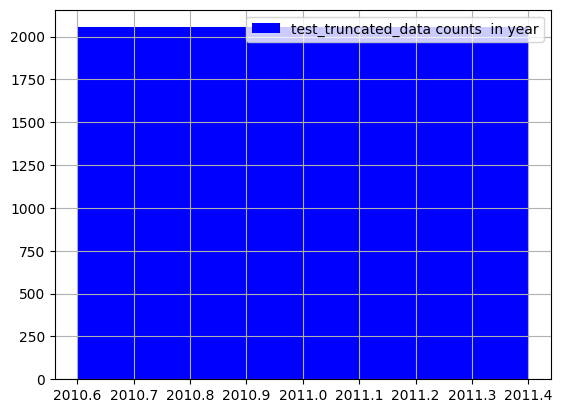

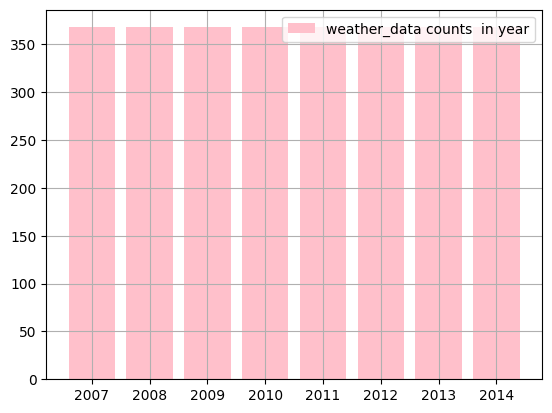

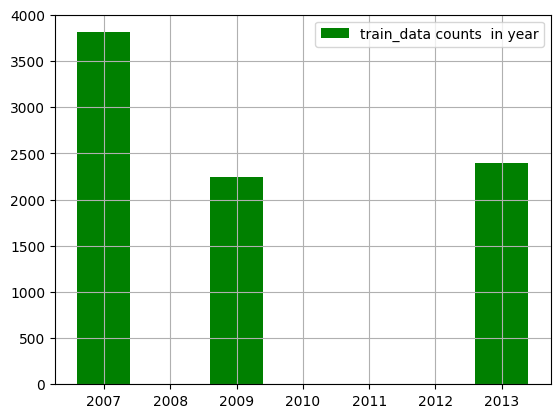

<Figure size 640x480 with 0 Axes>

In [456]:
def plot_datasetes():
    fig = plt.figure()

    plot_mas = test_truncated_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='blue', label='test_truncated_data counts  in year')
    plt.legend()
    plt.grid(True) 



    fig = plt.figure()
    plot_mas = weather_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='pink', label='weather_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки


    fig = plt.figure()
    #fig2 = plt.figure()

    plot_mas = train_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='green', label='train_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки


    fig = plt.figure()
    plot_mas = spray_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='spray_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки
    
    fig = plt.figure()
    plot_mas = test_truncated_data.groupby(['year'], group_keys=True,
                                           dropna=True).agg({'year': ['count']}).to_dict()[('year', 'count')] 
    plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='test_truncated_data counts  in year')
    plt.legend()
    plt.grid(True)   # лінії допоміжної сітки

plot_datasetes()

In [ ]:
def bar_chat(_data, grop_list_, agr_colum, agr_func):
    grop_list=[grop_list_]
    agg_func_math = {
        agr_colum: [agr_func]
    }

    plot_mas = _data.groupby(grop_list, group_keys=True, dropna=True).agg(agg_func_math).to_dict()[(agr_colum, agr_func)] 

    fig = plt.figure()
    plt.bar(plot_mas.keys(), plot_mas.values())
    plt.title(f'{grop_list_} {agr_colum} {agr_func} chart')
    
    plt.grid(True)   # лінії допоміжної сітки

In [ ]:
fig = plt.figure()
plot_mas = train_data.groupby(['month'], group_keys=True,
                              dropna=True).agg({'WnvPresent': ['sum']}).to_dict()[('WnvPresent', 'sum')] 
plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='WnvPresent sum month')
plt.legend()

plt.grid(False)   # лінії допоміжної сітки
#Date
fig = plt.figure()
plot_mas = train_data.groupby(['Date'], group_keys=True,
                              dropna=True).agg({'WnvPresent': ['sum']}).to_dict()[('WnvPresent', 'sum')] 
plt.bar(plot_mas.keys(), plot_mas.values(), color='red', label='WnvPresent sum Date')
plt.legend()

plt.grid(False)   # лінії допоміжної сітки

In [ ]:
train_data_adres.head()

In [ ]:
# Define our key point when map open it
map_ = folium.Map(location=[train_data_adres['Latitude'].mean(),  train_data_adres['Longitude'].mean()],
               tiles="Stamen Terrain", zoom_start=10, control_scale=False)

for la,lo in train_data_adres:
    folium.Marker(
        location=[la,lo],
        icon=folium.Icon(icon_color='white')
    ).add_to(map2)
# Plotting 
map2

In [ ]:
map_ = folium.Map(location=[train_data_adres['Latitude'].mean(),  train_data_adres['Longitude'].mean()],
               tiles="Stamen Terrain", zoom_start=10, control_scale=False)

folium.Marker(train_data_adres['Latitude','Longitude'], popup=train_data_adres['Trap']).add_to(map_)
map_

In [ ]:
#import folium
#Station_1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station_2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

#m = folium.Map(location=[45.5236, -122.6750])
#m = folium.Map(location=[42.391623, -88.089163], tiles="Stamen Terrain", zoom_start=13)


map_ = folium.Map(location=[spray_data['Latitude'].mean(),  spray_data['Longitude'].mean()],
               tiles="Stamen Terrain", zoom_start=10, control_scale=False)

folium.Marker([41.995,  -87.933], popup="CHICAGO O'HARE INTERNATIONAL AIRPORT").add_to(map_)
folium.Marker([41.786,  -88.089163], popup="CHICAGO MIDWAY INTL ARPT").add_to(map_)

folium.CircleMarker(
    location=[spray_data['Latitude'].mean(),  spray_data['Longitude'].mean()],
    radius=10,
    popup="spray_mean",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc",
).add_to(map_)


#train_data_adres
#for index, location_info in train_data.iterrows():
#    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["NumMosquitos"]).add_to(map_)

map_
